In [17]:
%matplotlib inline

import torch

from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [18]:
BATCH_SIZE = 4

# torchvision.datasets.MNIST outputs a set of PIL images
# We transform them to tensors
transform = transforms.ToTensor()

# Load and transform data
trainset = torchvision.datasets.MNIST('./mnist',
                train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

train_size = len(trainset)

testset = torchvision.datasets.MNIST('./mnist',
               train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_size = len(testset)

In [19]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [35]:
def sample_result(model) :
    model.to(device)
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    _, pred = torch.max(output, 1)
    
    print('Labels: ', labels.cpu().numpy())
    print('Predic: ', pred.cpu().numpy())
    ##print('Batch shape: ', images.size())
    show_batch(images.cpu())


In [21]:
# Multi Scheduler
#https://discuss.pytorch.org/t/two-optimizers-for-one-model/11085/6
class MultipleScheduler(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()


In [22]:
#Basic Model
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)
        #self.conv2 = nn.Conv2d(10, 10, 3, padding=1)
        self.fc1 = nn.Linear(14*14*10, 20)
        self.fc2 = nn.Linear(20, 10)
    
    def forward(self, x):
        #x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, 14*14*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model1 = Model1()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters())

params = 0
for arr in model1.parameters():
    #print(arr.size())
    pX = 1
    for x in arr.size():
        pX *= x
    params += pX
print("Number of parameters: " + str(params))


Number of parameters: 39530


In [23]:
#Model that illustrate how to keep frozen weights while training
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)
        #self.conv2 = nn.Conv2d(10, 10, 3, padding=1)
        self.fc1 = nn.Linear(14*14*10, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10,10) 
    
    def forward(self, x):
        #x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, 14*14*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
m2 = Model2()
criterion2 = nn.CrossEntropyLoss()
#MODO1 https://discuss.pytorch.org/t/how-to-perform-finetuning-in-pytorch/419/8?u=fcdl94
#In this way you can set different lr for each set of params
optimizer2 = optim.Adam( [ {"params": m2.conv1.parameters(), 'lr': 0.01}, {"params": m2.fc1.parameters()}], lr= 0.1)

#MODO2 -> suggested method to freeze only some layer here:
#  https://pytorch.org/docs/master/notes/autograd.html#excluding-subgraphs-from-backward
#optimizer = optim.Adam(m2.parameters())
#for param in m2.conv1.parameters():
#    param.requires_grad = False


In [24]:
#Model that illustrate how to keep frozen weights while training
class Model2BIS(nn.Module):
    def __init__(self):
        super(Model2BIS, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)
        #self.conv2 = nn.Conv2d(10, 10, 3, padding=1)
        self.fc1 = nn.Linear(14*14*10, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10,10) 
    
    def forward(self, x):
        #x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, 14*14*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
m2 = Model2()
criterion2 = nn.CrossEntropyLoss()
#MODO1 https://discuss.pytorch.org/t/how-to-perform-finetuning-in-pytorch/419/8?u=fcdl94
#In this way you can set different lr for each set of params
ignored_params = list(map(id, m2.fc3.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, m2.parameters())

optimizer2A = torch.optim.SGD(base_params, lr=0.1, momentum=0.9)
optimizer2B = torch.optim.SGD(m2.fc3.parameters(), lr=0, momentum=0)
scheduler2A = torch.optim.lr_scheduler.StepLR(optimizer2A, 2)
scheduler2B = torch.optim.lr_scheduler.StepLR(optimizer2B, 2)
scheduler = MultipleScheduler(optimizer2A,optimizer2B)
optimizer2 = scheduler



In [25]:
##Model with list module
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)
        #self.conv2 = nn.Conv2d(10, 10, 3, padding=1)
        self.fc1 = nn.Linear(14*14*10, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.ModuleList([nn.Linear(10,10), nn.Linear(10,10)])
        self.index = 0;
    
    def set_index(self, index ):
        if(index >= 0 and index <= 1):
            self.index = index
    
    def forward(self, x):
        #x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, 14*14*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3[self.index](x)
        return x
    
model3= Model3()
criterion3 = nn.CrossEntropyLoss()

optimizer3 = optim.Adam(model3.parameters())



In [26]:
#Model with block module
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)
        self.fcs = nn.Sequential(
            nn.Linear(14*14*10, 20),
            nn.ReLU(inplace=True),
            nn.Linear(20, 10)
        )
        #for param in self.conv1.parameters():
        #    param.requires_grad = False
    
    def forward(self, x):
        #x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, 14*14*10)
        x = self.fcs(x)
        return x
    
model4 = Model4()
criterion4 = nn.CrossEntropyLoss()

#optimizer4 = optim.Adam(filter( lambda p : p.requires_grad == True, model4.parameters()))
optimizer4 = optim.Adam(model4.fcs.parameters()) #this also works (without setting to False the requires_grads)


In [27]:
#Basic Model
class Model5(nn.Module):
    def __init__(self):
        super(Model5, self).__init__()
        self.c1 = nn.Conv2d(1, 10, 3, padding=1)
        self.f1 = nn.Linear(14*14*10, 20)
        self.f2 = nn.Linear(20, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c1(x)), 2)
        x = x.view(-1, 14*14*10)
        x = F.relu(self.f1(x))
        x = self.f2(x)
        return x
    
model5 = Model5()
criterion5 = nn.CrossEntropyLoss()
optimizer5 = optim.Adam(model1.parameters())


In [28]:
def train(model, optimizer, criterion, epochs=5):
    model.to(device)

    since = time.time()
    for epoch in range(0, epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = trainloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = testloader
                dataset_size = test_size
            
            running_loss = 0.0
            running_corrects = 0
              # Iterate over data.
            for inputs, labels in dataloader:
                #to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return model
    

In [29]:
def compute_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in  testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [8]:
#torch.save(model1.state_dict(),'MNISTModel/modelSD1.pt' )
#st_dict = torch.load('MNISTModel/modelSD1.pt')

Model1(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1960, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)

In [9]:
#model3.set_index(0)
#train(model3, optimizer, criterion, 1)
#model3.set_index(0)
#sample_result(model3)


In [10]:
#model4.state_dict().keys()
#model4.conv1.load_state_dict(torch.load("MNISTModel/modelSD1.pt"), False)

odict_keys(['conv1.weight', 'conv1.bias', 'fcs.0.weight', 'fcs.0.bias', 'fcs.2.weight', 'fcs.2.bias'])

Conv1.requires_grad = True
Epoch 0/0
----------
train Loss: 0.3871 Acc: 0.8842
val Loss: 0.2753 Acc: 0.9177
Training complete in 3m 19s
Labels:  [7 8 2 1]
Predic:  [7 8 2 1]
Conv1.equals= True
fcs.equals= False


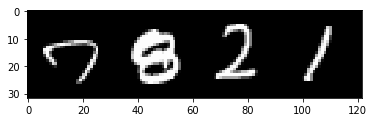

In [11]:
#Proof of working of method 2 (exclude from Optim. the freezing parameters)
print("Conv1.requires_grad = " + str(list(model4.conv1.parameters())[0].requires_grad))

torch.save(model4.fcs.state_dict(), "Model4BT.fcs.pt" )
torch.save(model4.conv1.state_dict(), "Model4BT.conv1.pt" )
train(model4, optimizer4, criterion4, 1) #TRAIN
sample_result(model4)                   #show results
torch.save(model4.fcs.state_dict(), "Model4AT.fcs.pt" )
torch.save(model4.conv1.state_dict(), "Model4AT.conv1.pt" )

conv1_BT = torch.load("Model4BT.conv1.pt")['weight']
conv1_AT = torch.load("Model4AT.conv1.pt")['weight']
print("Conv1.equals= " + str(torch.equal(conv1_BT,conv1_AT))) #returns True

fcs_BT = torch.load("Model4BT.fcs.pt")['0.weight']
fcs_AT = torch.load("Model4AT.fcs.pt")['0.weight']
print("fcs.equals= " + str(torch.equal(fcs_BT,fcs_AT))) #returns False


In [16]:
torch.save(m2.fc3.state_dict(), "Model2BT.fc3.pt" )
torch.save(m2.fc1.state_dict(), "Model2BT.fc1.pt" )
train(m2, optimizer2, criterion2, 5) #TRAIN
sample_result(m2)                   #show results
torch.save(m2.fc3.state_dict(), "Model2AT.fc3.pt" )
torch.save(m2.fc1.state_dict(), "Model2AT.fc1.pt" )

fc3_BT = torch.load("Model2BT.fc3.pt")['weight']
fc3_AT = torch.load("Model2AT.fc3.pt")['weight']
print("fc3.equals= " + str(torch.equal(fc3_BT,fc3_AT))) #returns True

fcs_BT = torch.load("Model2BT.fc1.pt")['weight']
fcs_AT = torch.load("Model2AT.fc1.pt")['weight']
print("fc2.equals= " + str(torch.equal(fcs_BT,fcs_AT))) #returns False

Epoch 0/4
----------
train Loss: 2.3562 Acc: 0.1017
val Loss: 2.3134 Acc: 0.0958
Epoch 1/4
----------
train Loss: 2.3578 Acc: 0.1026
val Loss: 2.3247 Acc: 0.1009
Epoch 2/4
----------
train Loss: 2.3578 Acc: 0.1019
val Loss: 2.3475 Acc: 0.1135
Epoch 3/4
----------
train Loss: 2.3597 Acc: 0.0998
val Loss: 2.4106 Acc: 0.1032
Epoch 4/4
----------
train Loss: 2.3590 Acc: 0.1001
val Loss: 2.3382 Acc: 0.1010
Training complete in 2m 23s


NameError: name 'sample_result' is not defined

In [124]:
model5 = Model5()
state5 = dict(model5.named_parameters())
state5.keys()


dict_keys(['c1.weight', 'c1.bias', 'f1.weight', 'f1.bias', 'f2.weight', 'f2.bias'])

In [141]:
##load parameter to another model with a translator dictionary

params5 = model5.named_parameters()
params4 = model4.named_parameters()

dict_params5 = dict(params5)
dict_params4 = dict(params4)


translator = { 
    "conv1.weight" : "c1.weight",
    "conv1.bias" : "c1.bias",
    "fcs.0.weight" : "f1.weight",
    "fcs.0.bias" : "f1.bias",
    "fcs.2.weight" : "f2.weight",
    "fcs.2.bias" : "f2.bias",
}

#for name4, param4 in params4:
#    if name4 in translator:
#        name5 = translator[name4]
#        dict_params5[name5].data.copy_(param4.data)
##OR
for name4 in translator.keys():
    name5 = translator[name4]
    dict_params5[name5].data.copy_(dict_params4[name4].data)
        
        
flag = True
for key in translator.keys():
    if not torch.equal(model5.state_dict()[translator[key]], model4.state_dict()[key]):
        flag = False
        
print(str(flag))
    
        
        

True


In [142]:
#train(model4, optimizer4, criterion4, 1)

print("Model 4: " + str(compute_accuracy(model4)))
print("Model 5: " + str(compute_accuracy(model5)))

Model 4: 93.26
Model 5: 93.26


In [30]:
train(model1, optimizer1, criterion1, 20) #TRAIN

Epoch 0/19
----------
train Loss: 0.3409 Acc: 0.8919
val Loss: 0.1636 Acc: 0.9490
Epoch 1/19
----------
train Loss: 0.1279 Acc: 0.9612
val Loss: 0.0910 Acc: 0.9722
Epoch 2/19
----------
train Loss: 0.0863 Acc: 0.9743
val Loss: 0.0761 Acc: 0.9780
Epoch 3/19
----------
train Loss: 0.0657 Acc: 0.9794
val Loss: 0.0702 Acc: 0.9775
Epoch 4/19
----------
train Loss: 0.0530 Acc: 0.9844
val Loss: 0.0700 Acc: 0.9787
Epoch 5/19
----------
train Loss: 0.0434 Acc: 0.9868
val Loss: 0.0765 Acc: 0.9769
Epoch 6/19
----------
train Loss: 0.0364 Acc: 0.9883
val Loss: 0.0613 Acc: 0.9815
Epoch 7/19
----------
train Loss: 0.0311 Acc: 0.9903
val Loss: 0.0775 Acc: 0.9782
Epoch 8/19
----------
train Loss: 0.0266 Acc: 0.9911
val Loss: 0.0627 Acc: 0.9829
Epoch 9/19
----------
train Loss: 0.0241 Acc: 0.9919
val Loss: 0.0667 Acc: 0.9822
Epoch 10/19
----------
train Loss: 0.0210 Acc: 0.9931
val Loss: 0.0745 Acc: 0.9806
Epoch 11/19
----------
train Loss: 0.0185 Acc: 0.9942
val Loss: 0.0752 Acc: 0.9824
Epoch 12/19
--

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

Labels:  [8 0 0 1]
Predic:  [8 0 0 1]


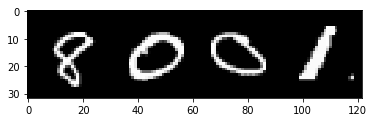

In [41]:
sample_result(model1) 